### import gym 
gym.version.VERSION

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from gridworld_env import GridworldEnv

In [2]:
env = GridworldEnv('') # Number of plan 

/Users/samueloliveira/opt/anaconda3/envs/maai-env/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


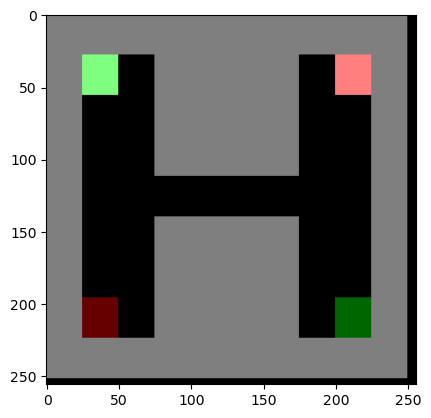

In [3]:
env.render()

In [4]:
env.observation_space

Box(-1.0, [8. 9. 5. 1. 8. 9. 5. 1.], (8,), float32)

In [5]:
print(env.reset())
#print(env.action_space.sample())
env.step([env.action_space[0].sample(),env.action_space[1].sample()])
#env.step(env.action_space.sample())

[1, 1, 0.0, 0.0, 1, 8, 0.0, 0.0]


(array([1., 1., 0., 0., 1., 8., 4., 0.]),
 [0, 0.0],
 [False, False],
 {'success': [True, False]})

In [6]:
env.verbose = True
print( env._get_agents_start_target_state())

((1, 1), (7, 8), (1, 8), (7, 1))


In [7]:
env.grid_map_shape

(9, 10)

In [8]:
env.observation_space

Box(-1.0, [8. 9. 5. 1. 8. 9. 5. 1.], (8,), float32)

In [9]:
env.action_space

{0: Discrete(5), 1: Discrete(5)}

[1, 1, 0.0, 0.0, 1, 8, 0.0, 0.0]


State 				 - Reward
[1. 1. 0. 0. 2. 8. 1. 0.] 			 [0, 0.0]
[2. 1. 1. 0. 1. 8. 2. 0.] 			 [0.0, 0.0]
[1. 1. 2. 0. 2. 8. 1. 0.] 			 [0.0, 0.0]
[1. 1. 3. 0. 3. 8. 1. 0.] 			 [0.0, 0.0]
[1. 1. 0. 0. 3. 8. 4. 0.] 			 [0, 0.0]
Total episode reward:  0.0


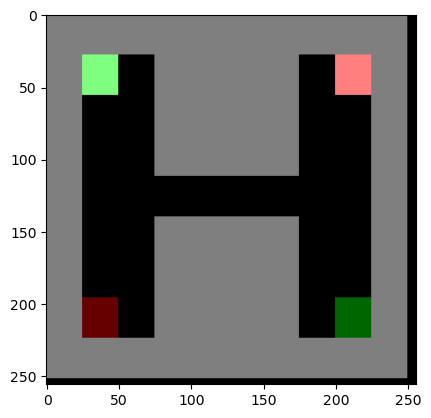

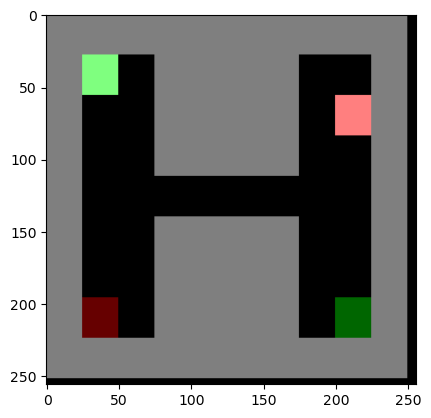

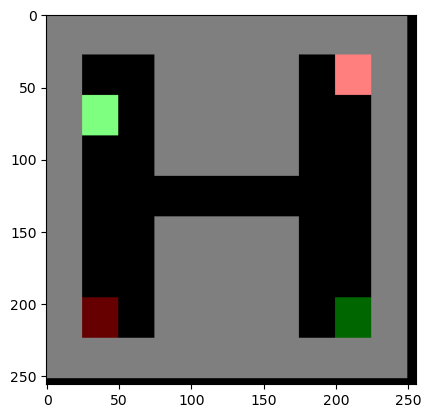

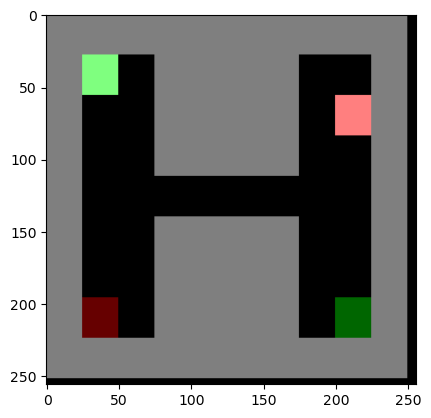

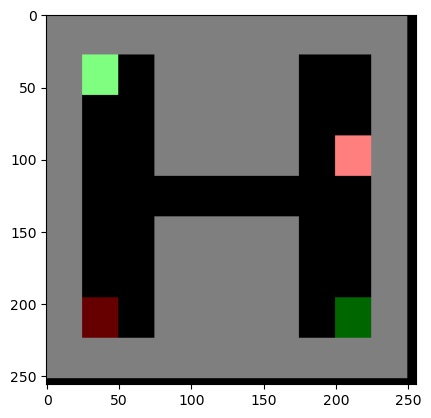

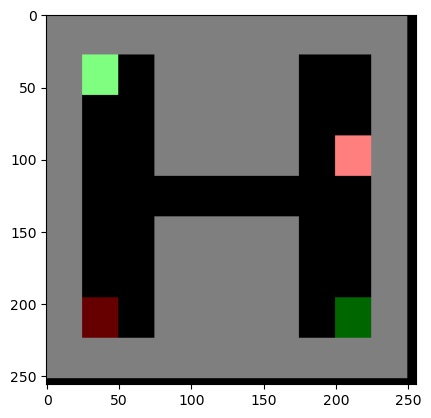

In [10]:
# Try random policy, seems to work
print(env.reset())
env.render()
print('State \t\t\t\t - Reward')
for i in range(5):
    move0,move1 = env.action_space[0].sample(),env.action_space[1].sample()
    obs , rewards, _, _ =  env.step([move0,move1]) 
    print(obs,'\t\t\t',rewards)
        
    env.render()
    
print('Total episode reward: ', env.episode_total_reward)

## Q-learning Example

In [12]:
# Q learning params
ALPHA = 0.1 # learning rate
GAMMA = 0.95 # reward discount
LEARNING_COUNT = 2
TEST_COUNT = 100

TURN_LIMIT = 1000
IS_MONITOR = True
from numba import jit

class Agents:

    def __init__(self, env):
        self.env = env
        self.episode_reward_1 = 0.0
        self.episode_reward_2 = 0.0
        #remember the actions in indices 2 and 6 are the previous actions
        # need to add another dim at the end to actually select next action
        self.q_val_1 = np.zeros(9*10*5*2*9*10*5*2*5).reshape(9,10,5,2,9,10,5,2,5).astype(np.float32)
        self.q_val_2 = np.zeros(9*10*5*2*9*10*5*2*5).reshape(9,10,5,2,9,10,5,2,5).astype(np.float32)

    def learn(self):
        # one episode learning
        state = self.env.reset()

        self.episode_reward_2=0
        self.episode_reward_1=0
        state=env.current_game_state
        done=[False,False]
        for t in range(TURN_LIMIT):
            if done[0]:
                act0=0
            elif done[1]:
                act1=1
            else:
                act0,act1 = env.action_space[0].sample(),env.action_space[1].sample()
            next_state, rewards,move_completed,info=  env.step([act0,act1]) 
            #act = self.env.action_space.sample() # random
            #next_state, reward, done, info = self.env.step(act, self.idx)
            assert len(next_state) == 8

            q_next_max_1 = np.max(self.q_val_1, axis=tuple([i for i in range(self.q_val_1.ndim) if i != 2]))
            q_next_max_2 = np.max(self.q_val_2, axis=tuple([i for i in range(self.q_val_2.ndim) if i != 6]))
            # Q <- Q + a(Q' - Q)
            # <=> Q <- (1-a)Q + a(Q')
            state=map(int,state)
            self.q_val_1[tuple(state)] = (1 - ALPHA) * self.q_val_1[tuple(state)]\
                                 + ALPHA * (rewards[0] + GAMMA * q_next_max_1)
            self.q_val_2[tuple(state)] = (1 - ALPHA) * self.q_val_2[tuple(state)]\
                                 + ALPHA * (rewards[1] + GAMMA * q_next_max_2)
            
            self.episode_reward_1 += rewards[0]
            self.episode_reward_2 += rewards[1]
            #self.env.render()

            if all(move_completed):
                return self.env.episode_total_reward,self.episode_reward_1,self.episode_reward_2
            else:
                state = next_state
                
        return self.env.episode_total_reward,self.episode_reward_1,self.episode_reward_2

    def test(self):
        state = self.env.reset()
        for t in range(TURN_LIMIT):
            norm_coords = state[self.idx * 3]
            act = np.argmax(self.q_val[int(64.*(norm_coords+1.)/2.)])
            next_state, reward, done, info = self.env.step(act, self.idx)
            if done:
                return self.env.episode_total_reward
            else:
                state = next_state
        return 0.0 # over limit

env = GridworldEnv('')
env.reset()
agents = Agents(env)

print("###### LEARNING #####")
reward_total_1 = 0.0
reward_total_2 = 0.0
for i in range(LEARNING_COUNT):
    print(i)
    total_reward,reward_1,reward_2=agents.learn()
    reward_total_1 += reward_1
    reward_total_2 += reward_2
print("episodes      : {}".format(LEARNING_COUNT))
print("agent 1 total reward  : {}".format(reward_total_1))
print("agent 1 average reward: {:.2f}".format(reward_total_1 / LEARNING_COUNT))
#print("agent 1 Q Value       :{}".format(agent.q_val))
print("agent 2 total reward  : {}".format(reward_total_2))
print("agent 2 average reward: {:.2f}".format(reward_total_2 / LEARNING_COUNT))
#print("agent 2 Q Value       :{}".format(agent2.q_val))

"""
print("###### TEST #####")
reward_total_1 = 0.0
reward_total_2 = 0.0
for i in range(TEST_COUNT):
    reward_total_1 += agent1.test()
    reward_total_2 += agent2.test()
print("episodes      : {}".format(TEST_COUNT))
print("agent 1 total reward  : {}".format(reward_total_1))
print("agent 1 average reward: {:.2f}".format(reward_total_1 / TEST_COUNT))
print("agent 2 total reward  : {}".format(reward_total_2))
print("agent 2 average reward: {:.2f}".format(reward_total_2 / TEST_COUNT))
"""


###### LEARNING #####
0
1
episodes      : 2
agent 1 total reward  : 13.0
agent 1 average reward: 6.50
agent 2 total reward  : 68.0
agent 2 average reward: 34.00


'\nprint("###### TEST #####")\nreward_total_1 = 0.0\nreward_total_2 = 0.0\nfor i in range(TEST_COUNT):\n    reward_total_1 += agent1.test()\n    reward_total_2 += agent2.test()\nprint("episodes      : {}".format(TEST_COUNT))\nprint("agent 1 total reward  : {}".format(reward_total_1))\nprint("agent 1 average reward: {:.2f}".format(reward_total_1 / TEST_COUNT))\nprint("agent 2 total reward  : {}".format(reward_total_2))\nprint("agent 2 average reward: {:.2f}".format(reward_total_2 / TEST_COUNT))\n'

In [19]:
Q_a1 = agents.q_val_1
Q_a1_mean=np.mean(Q_a1,axis=(tuple(i for i in range(Q_a1.ndim) if i != 0 and i!=1 and i!=2)))

policy_function1 = np.argmax( Q_a1_mean , axis = 2)

Q_a2 = agents.q_val_2 
Q_a2_mean=np.mean(Q_a2,axis=tuple(i for i in range(Q_a2.ndim) if i != 4 and i!=5 and i!=6))
policy_function2 = np.argmax( Q_a2_mean , axis = 2)
print(policy_function1)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


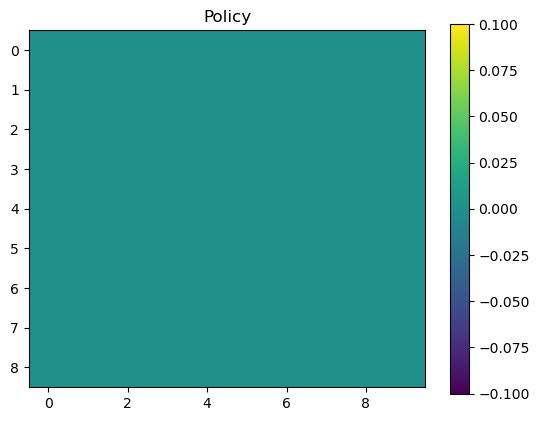

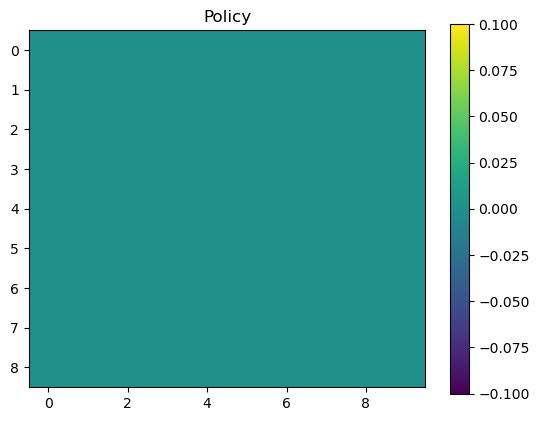

In [17]:
def plot_policy( policy_function ):

    plt.figure()
    plt.imshow( policy_function , interpolation='none' )
    plt.colorbar()

    for row in range( policy_function.shape[0] ):
        for col in range( policy_function.shape[1] ):
            if policy_function[row][col] == 0:
                continue 
            if policy_function[row][col] == 1:
                dx = 0; dy = .5
            if policy_function[row][col] == 2:
                dx = 0; dy = -.5
            if policy_function[row][col] == 3:
                dx = -.5; dy = 0
            if policy_function[row][col] == 4:
                dx = .5; dy = 0
            plt.arrow( col , row , dx , dy , shape='full', fc='w' , ec='w' , lw=3, length_includes_head=True, head_width=.2 )
    plt.title( 'Policy' )        
    plt.show() 
plot_policy(policy_function1)
plot_policy(policy_function2)

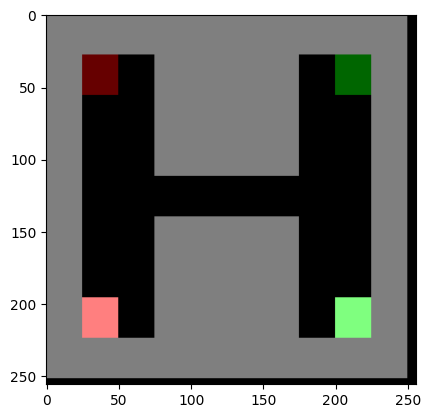

In [14]:
env.reset()
env.render()